# Autism Spectrum Disorder (ASD) Screening

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel, SelectKBest, mutual_info_regression, chi2
import numpy as np
from operator import itemgetter

## 1. Load Data

Autism_Data.arff – For this .arff format, I converted it into csv for better readability. And loaded it to a pandas dataframe.

In [5]:
import pandas as pd
from scipy.io import arff

# Load the ARFF file
data, meta = arff.loadarff('/Users/kavanamanvi/Desktop/AML/FinalProject/autism/Autism-Adult-Data.arff')

# Convert to Pandas DataFrame
df = pd.DataFrame(data)

# Decode byte-string columns if necessary
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Save as CSV
df.to_csv('/Users/kavanamanvi/Desktop/AML/FinalProject/autism/Autism-Adult-Data.csv', index=False)

print("ARFF file successfully converted to CSV!")

ARFF file successfully converted to CSV!


In [6]:
df = pd.read_csv("/Users/kavanamanvi/Desktop/AML/FinalProject/autism/Autism-Adult-Data.csv")

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,26.0,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,24.0,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,27.0,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,35.0,f,White-European,no,yes,United States,no,6.0,18 and more,Self,NO
4,1,0,0,0,0,0,0,1,0,0,40.0,f,?,no,no,Egypt,no,2.0,18 and more,?,NO


## 2. Data Cleaning

I corrected some spelling errors and found many missing ethnicity values

In [10]:
df.rename(columns={"jundice": "jaundice"}, inplace=True)
df.rename(columns={"contry_of_res": "country"}, inplace=True)

In [11]:
#since this is an adult autism dataset, removing it coz all people are 18+
df= df.drop(columns=['age_desc'], errors='ignore')
df= df.drop(columns=['austim'], errors='ignore')
#df= df.drop(columns=['result'], errors='ignore')

**Missig values** : Replacing age missing values with it's most frequent value, mode. I decided to drop missing ethnicity values since they are mostly from "No autism." This helps my model focus on autism characteristics and improves sensitivity while ensuring minimal bias.

df['ethnicity'] = df['ethnicity'].replace('?', np.nan)
df['relation'] = df['relation'].replace('?', np.nan)

In [14]:
df = df[~df.isin(['?']).any(axis=1)]

In [15]:
df.isna().sum()

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
country            0
used_app_before    0
result             0
relation           0
Class/ASD          0
dtype: int64

In [16]:
df=df.dropna()
df.isna().sum()

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
country            0
used_app_before    0
result             0
relation           0
Class/ASD          0
dtype: int64

In [17]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
A1_Score,609.0,NaN,NaN,NaN,0.740558,0.438689,0.0,0.0,1.0,1.0,1.0
A2_Score,609.0,NaN,NaN,NaN,0.469622,0.499487,0.0,0.0,0.0,1.0,1.0
A3_Score,609.0,NaN,NaN,NaN,0.481117,0.500054,0.0,0.0,0.0,1.0,1.0
A4_Score,609.0,NaN,NaN,NaN,0.520525,0.499989,0.0,0.0,1.0,1.0,1.0
A5_Score,609.0,NaN,NaN,NaN,0.525452,0.499762,0.0,0.0,1.0,1.0,1.0
A6_Score,609.0,NaN,NaN,NaN,0.307061,0.461654,0.0,0.0,0.0,1.0,1.0
A7_Score,609.0,NaN,NaN,NaN,0.428571,0.495278,0.0,0.0,0.0,1.0,1.0
A8_Score,609.0,NaN,NaN,NaN,0.665025,0.47237,0.0,0.0,1.0,1.0,1.0
A9_Score,609.0,NaN,NaN,NaN,0.341544,0.474617,0.0,0.0,0.0,1.0,1.0
A10_Score,609.0,NaN,NaN,NaN,0.597701,0.490765,0.0,0.0,1.0,1.0,1.0


In [18]:
num_rows, num_cols = df.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 609
Number of columns: 19


In [19]:
df.head(3)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,country,used_app_before,result,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,26.0,f,White-European,no,United States,no,6.0,Self,NO
1,1,1,0,1,0,0,0,1,0,1,24.0,m,Latino,no,Brazil,no,5.0,Self,NO
2,1,1,0,1,1,0,1,1,1,1,27.0,m,Latino,yes,Spain,no,8.0,Parent,YES


## 3. Exploration

<Figure size 1200x600 with 0 Axes>

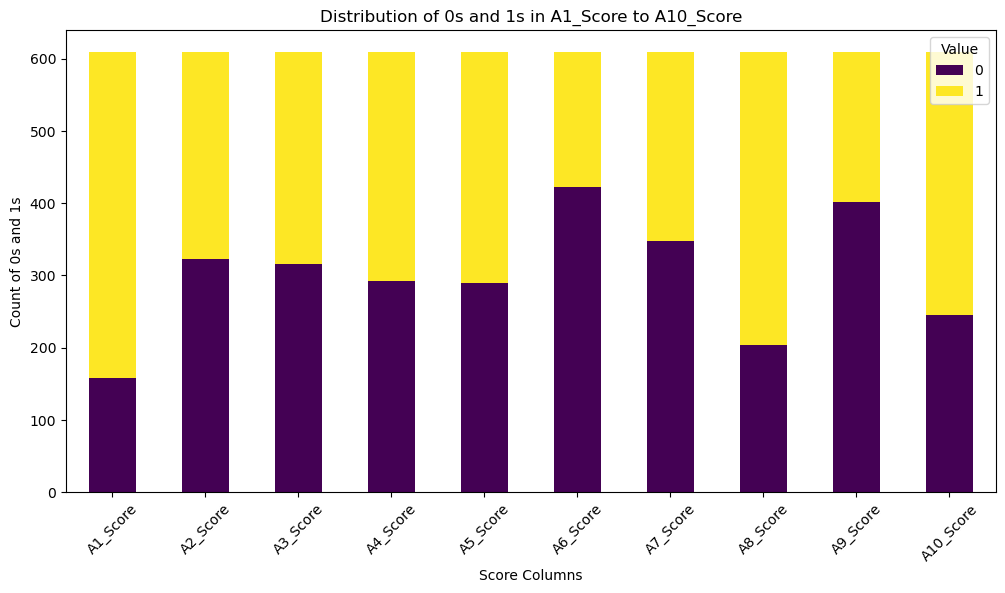

In [21]:
score_columns = [f"A{i}_Score" for i in range(1, 11)]
plt.figure(figsize=(12, 6))
score_counts = {col: df[col].value_counts().sort_index() for col in score_columns}
score_counts_df = pd.DataFrame(score_counts).T  # Transpose for better plotting
score_counts_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.xlabel("Score Columns")
plt.ylabel("Count of 0s and 1s")
plt.title("Distribution of 0s and 1s in A1_Score to A10_Score")
plt.legend(title="Value")
plt.xticks(rotation=45)
plt.show()

In the Autism Spectrum Disorder (ASD) dataset for adults, the **A_1 to A_10** features correspond to the ten behavioral screening questions derived from the **AQ-10 (Autism Spectrum Quotient - 10 items)** questionnaire. These questions assess various traits and behaviors associated with ASD, focusing on social interaction, communication, and repetitive behaviors. Below is the general interpretation of these questions:  

1. **A_1** – Difficulty noticing small details in surroundings  
2. **A_2** – Struggles with social interactions and making friends  
3. **A_3** – Finds it challenging to understand others' emotions  
4. **A_4** – Prefers routine and feels distressed when routines change  
5. **A_5** – Strong focus on specific interests or hobbies  
6. **A_6** – Finds it difficult to engage in conversations or follow social cues  
7. **A_7** – Notices patterns or details that others may overlook  
8. **A_8** – Prefers solitude over social gatherings  
9. **A_9** – Feels overwhelmed in noisy or crowded environments  
10. **A_10** – Has difficulty adapting to unexpected changes  

These questions are typically answered on a **binary scale (Yes/No or 1/0)**

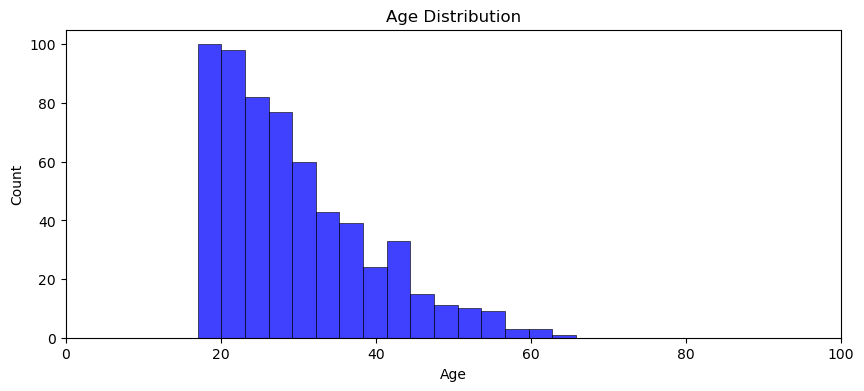

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Age Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df["age"], color="blue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.xlim(0, 100)  # Set x-axis range from 0 to 100
plt.show()

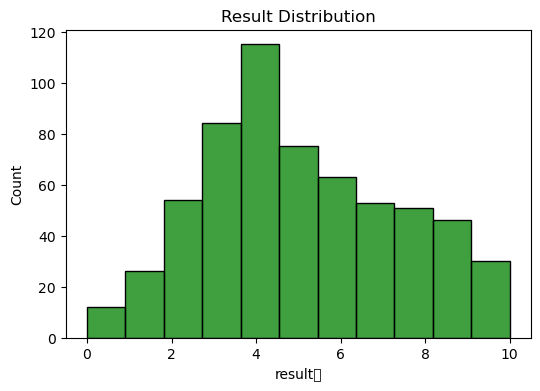

In [24]:
# Plot Age Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df["result"],  color="green")
plt.xlabel("result	")
plt.ylabel("Count")
plt.title("Result Distribution")
plt.show()

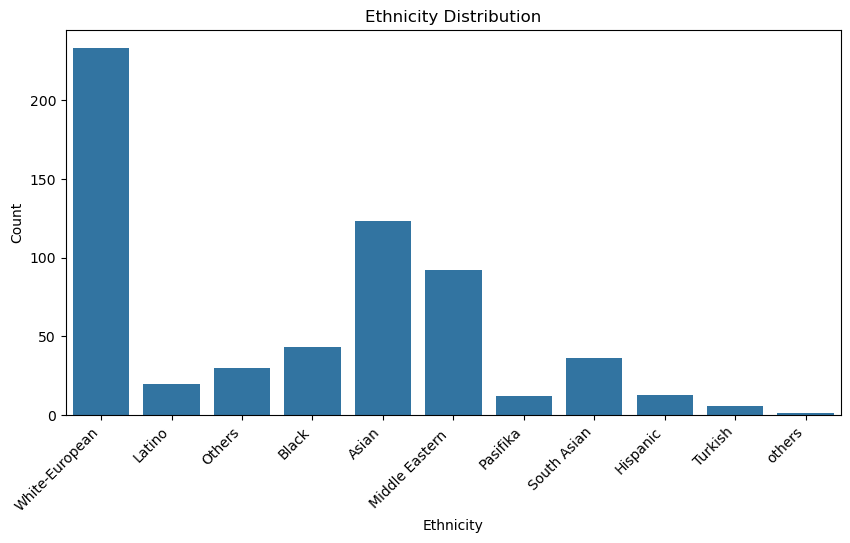

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df["ethnicity"]) 
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.title("Ethnicity Distribution")
plt.show()

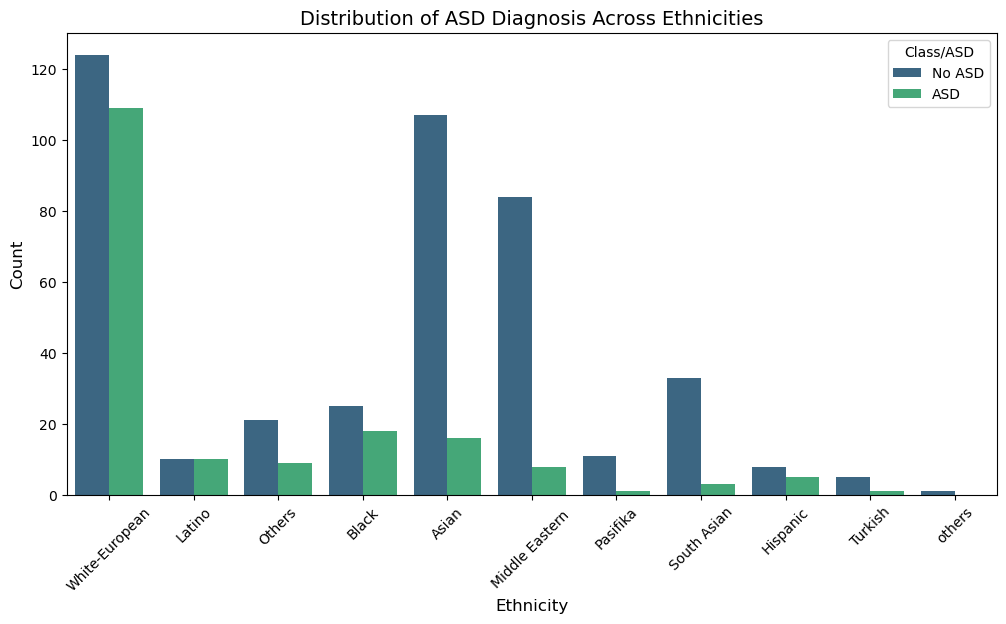

In [26]:
plt.figure(figsize=(12, 6))

sns.countplot(data=df, x='ethnicity', hue='Class/ASD', palette='viridis')

# Labeling
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.xlabel("Ethnicity", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of ASD Diagnosis Across Ethnicities", fontsize=14)
plt.legend(title="Class/ASD", labels=["No ASD", "ASD"])

# Show the plot
plt.show()

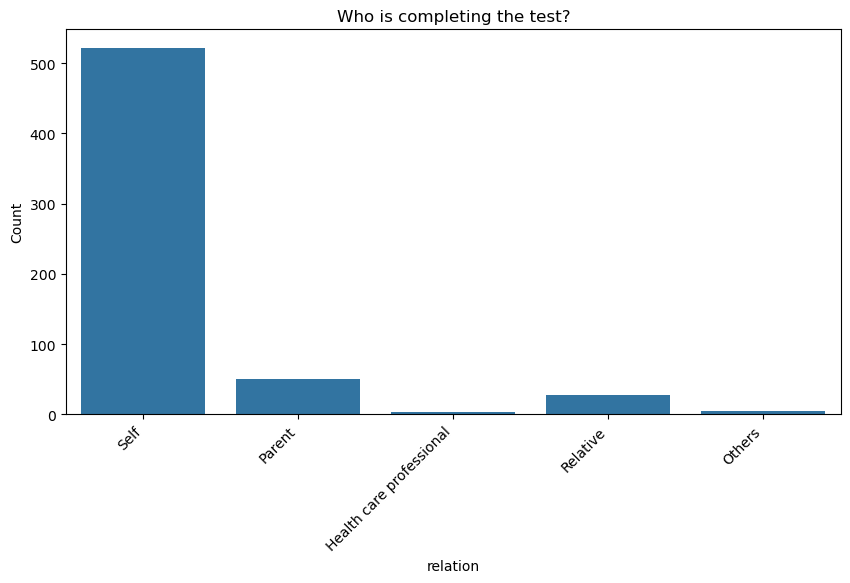

In [27]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df["relation"]) 
plt.xticks(rotation=45, ha="right")
plt.xlabel("relation")
plt.ylabel("Count")
plt.title("Who is completing the test?")
plt.show()

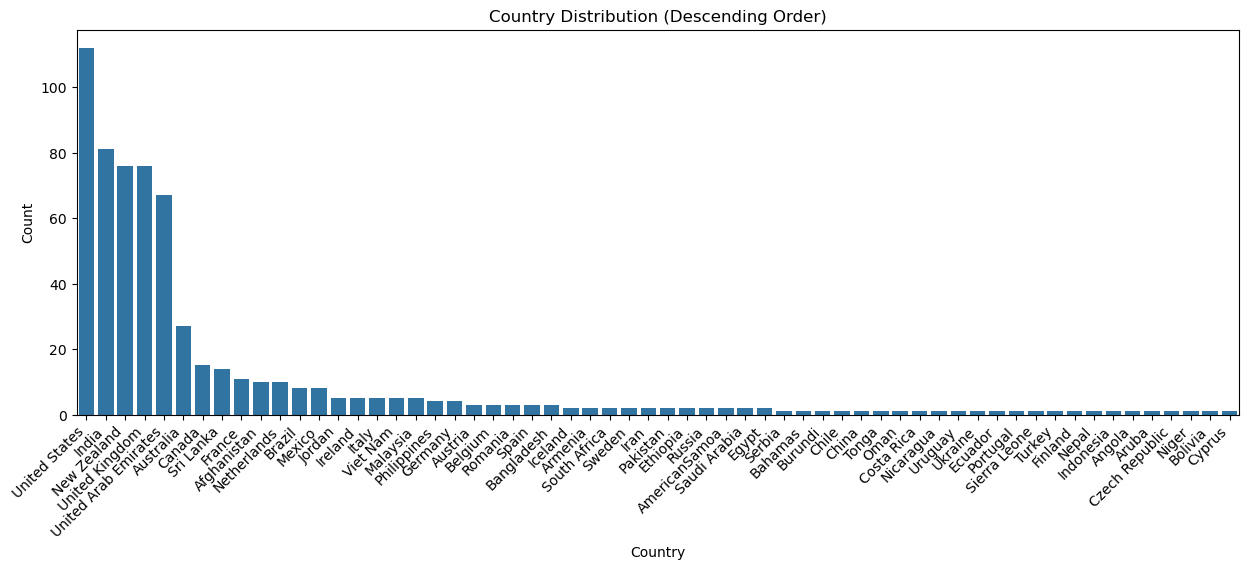

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each country and sort in descending order
country_counts = df["country"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 5))
sns.countplot(x=pd.Categorical(df["country"], categories=country_counts.index, ordered=True), order=country_counts.index)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Country Distribution (Descending Order)")
plt.show()


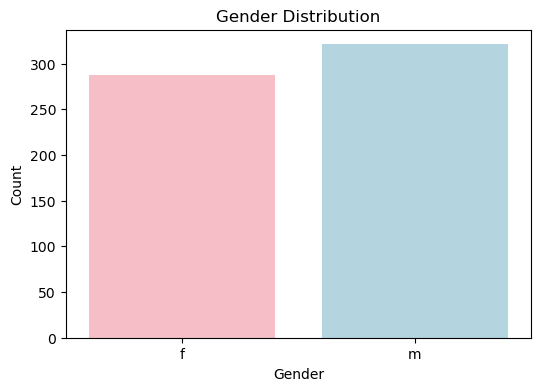

In [29]:
df["gender"] = df["gender"].str.lower()  # Normalize casing
custom_palette = {"f": "lightpink", "m": "lightblue"}
plt.figure(figsize=(6, 4))
sns.countplot(x="gender", data=df, hue="gender", palette=custom_palette, legend=False)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")
plt.show()

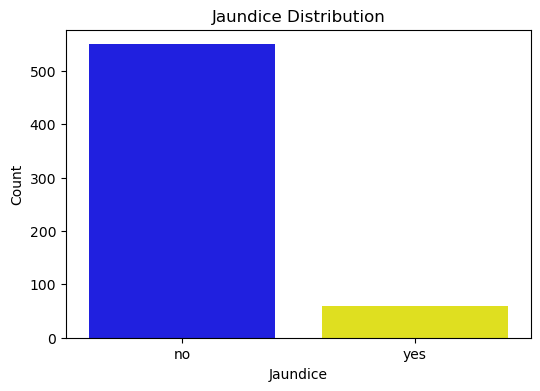

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'jaundice' column values are in lowercase
df["jaundice"] = df["jaundice"].str.lower()

# Define custom colors for the categories
custom_palette = {"no": "blue", "yes": "yellow"}

plt.figure(figsize=(6, 4))

# Create the count plot without hue
sns.countplot(x="jaundice", data=df, palette=custom_palette)

# Labels and title
plt.xlabel("Jaundice")
plt.ylabel("Count")
plt.title("Jaundice Distribution")

# Show the plot
plt.show()


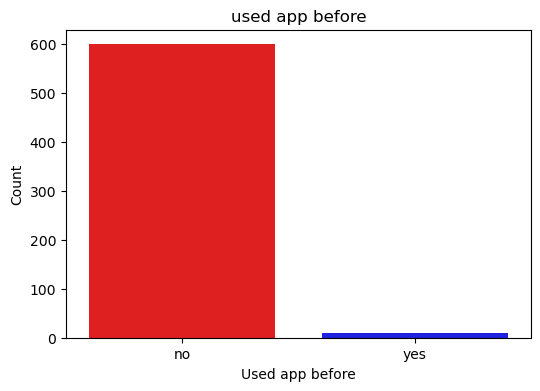

In [31]:
# Define custom colors for the categories
custom_palette = {"no": "red", "yes": "blue"}

plt.figure(figsize=(6, 4))

# Create the count plot without hue
sns.countplot(x="used_app_before", data=df, palette=custom_palette)

# Labels and title
plt.xlabel("Used app before")
plt.ylabel("Count")
plt.title("used app before")

# Show the plot
plt.show()


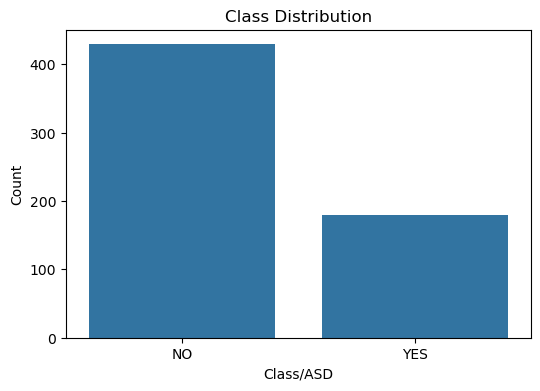

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Class/ASD"])

# Labels and title
plt.xlabel("Class/ASD")
plt.ylabel("Count")
plt.title("Class Distribution")

# Show the plot
plt.show()

In [33]:
df['Class/ASD'].value_counts()

Class/ASD
NO     429
YES    180
Name: count, dtype: int64

In [34]:
df["Class/ASD"] = df["Class/ASD"].replace({"YES": 1, "NO": 0}).astype(int)

In [35]:
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()


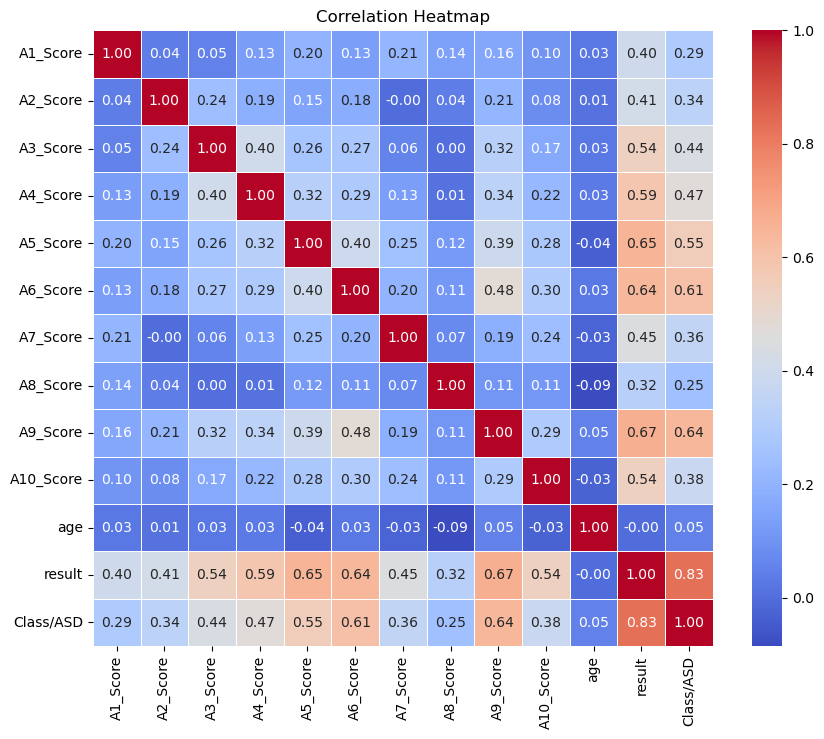

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Computing the correlation matrix
correlation_matrix = df_numeric.corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Display the plot
plt.title("Correlation Heatmap")
plt.show()


## 4. Data Preprocessing

In [38]:
#remove results column which has high correlation 
df= df.drop(columns=['result'], errors='ignore')

 covert yes/no, male/female to 0/1, normalization-minmax,remove col with variance

In [40]:
df.replace({'yes': 1, 'no': 0}, inplace=True)
df.replace({'m': 1, 'f': 0}, inplace=True)
df["Class/ASD"] = df["Class/ASD"].replace({"YES": 1, "NO": 0}).astype(int)

In [41]:
df.head(3)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,country,used_app_before,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,26.0,0,White-European,0,United States,0,Self,0
1,1,1,0,1,0,0,0,1,0,1,24.0,1,Latino,0,Brazil,0,Self,0
2,1,1,0,1,1,0,1,1,1,1,27.0,1,Latino,1,Spain,0,Parent,1


In [42]:
# Step 1: Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=['country', 'relation', 'ethnicity'])
# Step 2: Convert all boolean columns to int (1 and 0)
bool_columns = df_encoded.select_dtypes(include=bool).columns
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)
df_encoded.head(3)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,used_app_before,Class/ASD,country_Afghanistan,country_AmericanSamoa,country_Angola,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Bahamas,country_Bangladesh,country_Belgium,country_Bolivia,country_Brazil,country_Burundi,country_Canada,country_Chile,country_China,country_Costa Rica,country_Cyprus,country_Czech Republic,country_Ecuador,country_Egypt,country_Ethiopia,country_Finland,country_France,country_Germany,country_Iceland,country_India,country_Indonesia,country_Iran,country_Ireland,country_Italy,country_Jordan,country_Malaysia,country_Mexico,country_Nepal,country_Netherlands,country_New Zealand,country_Nicaragua,country_Niger,country_Oman,country_Pakistan,country_Philippines,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Sierra Leone,country_South Africa,country_Spain,country_Sri Lanka,country_Sweden,country_Tonga,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Viet Nam,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others
0,1,1,1,1,0,0,1,1,0,0,26.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,1,0,1,0,0,0,1,0,1,24.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1,1,0,1,1,0,1,1,1,1,27.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [43]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Create a copy of df_encoded to avoid modifying the original
df_normalized = df_encoded.copy()

# Normalize the 'age' column
df_normalized['age'] = scaler.fit_transform(df_normalized[['age']])
df_normalized.head(3)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,used_app_before,Class/ASD,country_Afghanistan,country_AmericanSamoa,country_Angola,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Bahamas,country_Bangladesh,country_Belgium,country_Bolivia,country_Brazil,country_Burundi,country_Canada,country_Chile,country_China,country_Costa Rica,country_Cyprus,country_Czech Republic,country_Ecuador,country_Egypt,country_Ethiopia,country_Finland,country_France,country_Germany,country_Iceland,country_India,country_Indonesia,country_Iran,country_Ireland,country_Italy,country_Jordan,country_Malaysia,country_Mexico,country_Nepal,country_Netherlands,country_New Zealand,country_Nicaragua,country_Niger,country_Oman,country_Pakistan,country_Philippines,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Sierra Leone,country_South Africa,country_Spain,country_Sri Lanka,country_Sweden,country_Tonga,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Viet Nam,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others
0,1,1,1,1,0,0,1,1,0,0,0.024590,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,1,0,1,0,0,0,1,0,1,0.019126,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1,1,0,1,1,0,1,1,1,1,0.027322,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [44]:
num_columns = df_normalized.shape[1]
print(f"Number of columns: {num_columns}")

Number of columns: 91


## 5. Feature selection

In [46]:
# Function to apply Low Variance Filter
def apply_low_variance_filter(X, threshold=0.5):
    # Low Variance Filter - removes features with variance below the threshold
    sel = VarianceThreshold(threshold=threshold)
    X_filtered = sel.fit_transform(X)
    return X_filtered

In [47]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def apply_feature_selection(X, y, fs_type):
    """
    Applies feature selection to normalized data based on specified method.
    
    Parameters:
    X (pd.DataFrame): Normalized feature matrix
    y (pd.Series): Target variable
    fs_type (int): 0=All features, 1=MI, 2=RFE, 3=CMIM+RF
    
    Returns:
    pd.DataFrame: Selected feature subset
    """
    
    if fs_type == 0:
        return X  # Return all features
    
    elif fs_type == 1:
        # Mutual Information (MI)
        selector = SelectKBest(mutual_info_classif, k=10)  # Top 50% features
        return pd.DataFrame(selector.fit_transform(X, y), 
                          columns=X.columns[selector.get_support()])
    
    elif fs_type == 2:
        # Recursive Feature Elimination (RFE)
        estimator = SVC(kernel="linear")
        selector = RFECV(estimator, cv=5, scoring='accuracy')
        return pd.DataFrame(selector.fit_transform(X, y), 
                          columns=X.columns[selector.get_support()])
    
    elif fs_type == 3:
        # CMIM-inspired RF-based Selection
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X, y)
        cmim_mask = rf.feature_importances_ > np.median(rf.feature_importances_)
        return X.loc[:, cmim_mask]
    
    else:
        raise ValueError("Invalid fs_type (0-3 only)")

# Usage example:
# X_selected = apply_feature_selection(X_normalized, y_target, fs_type=1)


## 6. Model Training

In [49]:
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.model_selection import cross_validate


In [50]:
y_normalized = df_normalized['Class/ASD']  # Target variable
X_normalized = df_normalized.drop(columns=['Class/ASD'])  # Features

In [51]:
y = df['Class/ASD']  # Target variable
X = df.drop(columns=['Class/ASD'])  # Features

In [52]:
y_encoded= df_encoded['Class/ASD']  # Target variable
X_encoded = df_encoded.drop(columns=['Class/ASD'])  # Features

In [120]:
from sklearn.model_selection import GridSearchCV

def tune_and_evaluate(X, y, model_type, rand_st=42):
    param_grids = {
        1: {  # XGBoost
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        },
        2: {  # SVM
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.1, 1],
            'class_weight': [None, 'balanced']
        },
        3: {  # Logistic Regression
            'C': [0.001, 0.01, 0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear'],
            'penalty': ['l2', None]
        },
        4: {  # Random Forest
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'class_weight': ['balanced', None]
        },
        5: {  # MLP
            'hidden_layer_sizes': [(50,), (100,), (50,50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01]
        }
    }

    base_models = {
        1: XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=rand_st),
        2: SVC(kernel="rbf", probability=True, random_state=rand_st),
        3: LogisticRegression(max_iter=1000, random_state=rand_st),
        4: RandomForestClassifier(random_state=rand_st),
        5: MLPClassifier(max_iter=300, random_state=rand_st)
    }

    medical_scorer = make_scorer(sensitivity)
    model_names = {1: "XGBoost", 2: "SVM", 3: "LogReg", 4: "RandomForest", 5: "MLP"}

    grid_search = GridSearchCV(
        estimator=base_models[model_type],
        param_grid=param_grids[model_type],
        scoring=medical_scorer,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=rand_st),
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\n=== Tuning {model_names[model_type]} ===")
    grid_search.fit(X, y)
    
    # Print best parameters with formatting
    print("\n🔧 Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"{param:20}: {value}")
    
    # Evaluate best model
    best_model = grid_search.best_estimator_
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_st)
    scores = cross_validate(best_model, X, y, scoring=scorers, cv=cv)
    
    # Print metrics
    print(f"\n📊 Best Model Performance:")
    print(f"AUC: {np.mean(scores['test_roc_auc']):.2f} (±{np.std(scores['test_roc_auc'])*2:.2f})")
    print(f"Sensitivity: {np.mean(scores['test_Sensitivity']):.2f} (±{np.std(scores['test_Sensitivity'])*2:.2f})")
    print(f"Specificity: {np.mean(scores['test_Specificity']):.2f} (±{np.std(scores['test_Specificity'])*2:.2f})")
    print(f"Accuracy: {np.mean(scores['test_Accuracy']):.2f} (±{np.std(scores['test_Accuracy'])*2:.2f})")
    
    return best_model


In [126]:
# Full Pipeline Execution - Now prints accuracy
def run_pipeline(X, y, fs_type, model_type):
    X_selected = apply_feature_selection(X, y, fs_type)
    auc, sens, spec, acc = train_and_evaluate(X_selected, y, model_type)

    print(f"Feature Selection: {fs_type}, Model: {model_type}")
    print(f"AUC: {auc:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}, Accuracy: {acc:.4f}\n")
    
    return auc, sens, spec, acc

In [128]:
run_pipeline(X_normalized, y_normalized, fs_type=1, model_type=1)


Training and Evaluating Model: XGBoost
XGBoost Acc: 0.95 (+/- 0.04)
XGBoost AUC: 0.93 (+/- 0.06)
XGBoost Sensitivity: 0.90 (+/- 0.13)
XGBoost Specificity: 0.97 (+/- 0.05)
CV Runtime: 0.33372974395751953
Feature Selection: 1, Model: 1
AUC: 0.9325, Sensitivity: 0.9000, Specificity: 0.9651, Accuracy: 0.9458



(0.9325307797537619, 0.9, 0.9650615595075239, 0.9458338978458205)

In [130]:
for mt in range(1,6):
    for fs in range(4):
        run_pipeline(X_normalized, y_normalized, fs_type=fs, model_type=mt)


Training and Evaluating Model: XGBoost
XGBoost Acc: 0.97 (+/- 0.02)
XGBoost AUC: 0.96 (+/- 0.03)
XGBoost Sensitivity: 0.94 (+/- 0.07)
XGBoost Specificity: 0.98 (+/- 0.03)
CV Runtime: 1.1390609741210938
Feature Selection: 0, Model: 1
AUC: 0.9629, Sensitivity: 0.9444, Specificity: 0.9814, Accuracy: 0.9705


Training and Evaluating Model: XGBoost
XGBoost Acc: 0.94 (+/- 0.03)
XGBoost AUC: 0.92 (+/- 0.05)
XGBoost Sensitivity: 0.88 (+/- 0.12)
XGBoost Specificity: 0.96 (+/- 0.05)
CV Runtime: 0.45519399642944336
Feature Selection: 1, Model: 1
AUC: 0.9230, Sensitivity: 0.8833, Specificity: 0.9627, Accuracy: 0.9392


Training and Evaluating Model: XGBoost
XGBoost Acc: 0.97 (+/- 0.03)
XGBoost AUC: 0.97 (+/- 0.04)
XGBoost Sensitivity: 0.95 (+/- 0.08)
XGBoost Specificity: 0.98 (+/- 0.04)
CV Runtime: 0.4003019332885742
Feature Selection: 2, Model: 1
AUC: 0.9657, Sensitivity: 0.9500, Specificity: 0.9814, Accuracy: 0.9721


Training and Evaluating Model: XGBoost
XGBoost Acc: 0.97 (+/- 0.02)
XGBoost A

# Hyperparameters